# M5 Forecasting Time Series Analysis

This notebook performs time series forecasting on the M5 Forecasting dataset using various models including LSTM, RNN, CNN, and ARIMA.

### Step 1: Import Required Libraries

Import all necessary libraries for data manipulation, visualization, modeling, and evaluation.

In [26]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, SimpleRNN, Conv1D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pmdarima as pm
from pmdarima import auto_arima
from tqdm import tqdm
import os

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("Libraries imported successfully!")

Libraries imported successfully!


### Step 2: Load and Merge CSV Files

Load the M5 dataset files and merge them into a unified dataframe for analysis.

In [27]:
# Load CSV files
print("Loading CSV files...")
sales_df = pd.read_csv(r"C:\Users\n\Downloads\m5-forecasting-accuracy\sales_train_validation.csv")
calendar_df = pd.read_csv(r"C:\Users\n\Downloads\m5-forecasting-accuracy\calendar.csv")
prices_df = pd.read_csv(r"C:\Users\n\Downloads\m5-forecasting-accuracy\sell_prices.csv")
submission_df = pd.read_csv(r"C:\Users\n\Downloads\m5-forecasting-accuracy\sample_submission.csv")

print(f"Sales shape: {sales_df.shape}")
print(f"Calendar shape: {calendar_df.shape}")
print(f"Prices shape: {prices_df.shape}")
print(f"Submission shape: {submission_df.shape}")

# Melt sales data to long format
sales_long = sales_df.melt(id_vars=['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], 
                          var_name='d', value_name='sales')

print(f"Sales long shape: {sales_long.shape}")

# Merge with calendar
merged_df = sales_long.merge(calendar_df, on='d', how='left')

# Merge with prices
merged_df = merged_df.merge(prices_df, on=['store_id', 'item_id', 'wm_yr_wk'], how='left')

print(f"Merged dataframe shape: {merged_df.shape}")
print("Data merged successfully!")
print(merged_df.head())

Loading CSV files...
Sales shape: (2922, 1919)
Calendar shape: (1969, 14)
Prices shape: (32579, 4)
Submission shape: (60980, 29)
Sales long shape: (5592708, 7)
Merged dataframe shape: (5592708, 21)
Data merged successfully!
         item_id    dept_id   cat_id store_id state_id   d  \
0  HOBBIES_1_151  HOBBIES_1  HOBBIES     CA_1       CA  id   
1  HOBBIES_1_152  HOBBIES_1  HOBBIES     CA_1       CA  id   
2  HOBBIES_1_153  HOBBIES_1  HOBBIES     CA_1       CA  id   
3  HOBBIES_1_154  HOBBIES_1  HOBBIES     CA_1       CA  id   
4  HOBBIES_1_155  HOBBIES_1  HOBBIES     CA_1       CA  id   

                           sales date  wm_yr_wk weekday  ...  month  year  \
0  HOBBIES_1_151_CA_1_validation  NaN       NaN     NaN  ...    NaN   NaN   
1  HOBBIES_1_152_CA_1_validation  NaN       NaN     NaN  ...    NaN   NaN   
2  HOBBIES_1_153_CA_1_validation  NaN       NaN     NaN  ...    NaN   NaN   
3  HOBBIES_1_154_CA_1_validation  NaN       NaN     NaN  ...    NaN   NaN   
4  HOBBIES_1_155_C

### Step 3: Exploratory Data Analysis

Examine the data structure, check for missing values, compute correlations, and visualize sales over time.

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5592708 entries, 0 to 5592707
Data columns (total 21 columns):
 #   Column        Dtype  
---  ------        -----  
 0   item_id       object 
 1   dept_id       object 
 2   cat_id        object 
 3   store_id      object 
 4   state_id      object 
 5   d             object 
 6   sales         object 
 7   date          object 
 8   wm_yr_wk      float64
 9   weekday       object 
 10  wday          float64
 11  month         float64
 12  year          float64
 13  event_name_1  object 
 14  event_type_1  object 
 15  event_name_2  object 
 16  event_type_2  object 
 17  snap_CA       float64
 18  snap_TX       float64
 19  snap_WI       float64
 20  sell_price    float64
dtypes: float64(8), object(13)
memory usage: 896.0+ MB
None

Missing values:
item_id               0
dept_id               0
cat_id                0
store_id              0
state_id              0
d                     0
sales                 0
date      

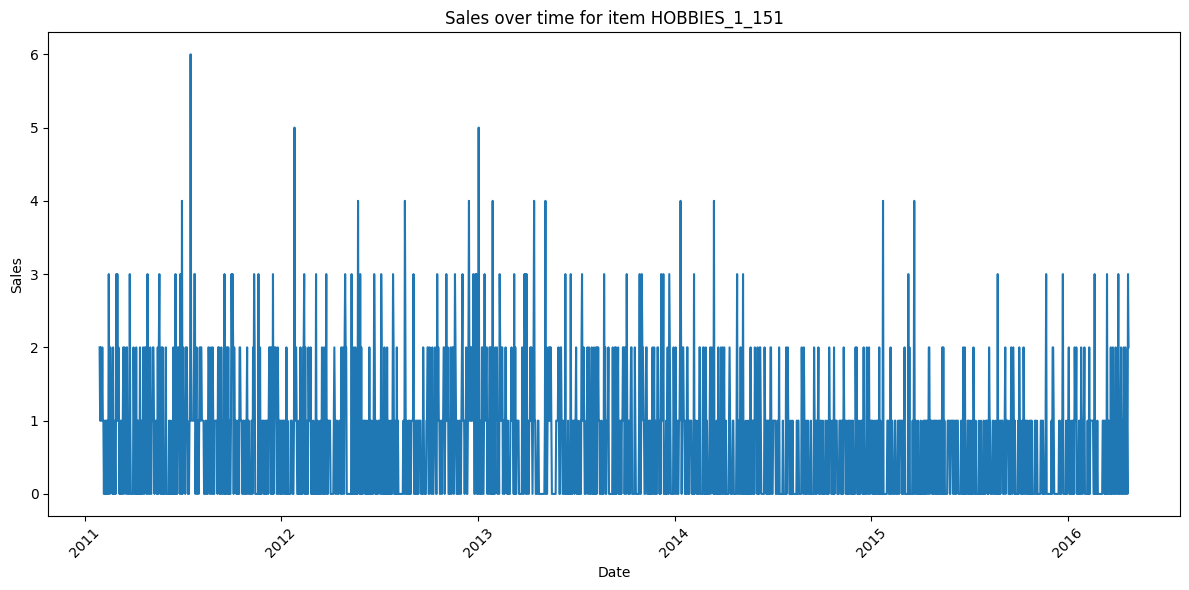

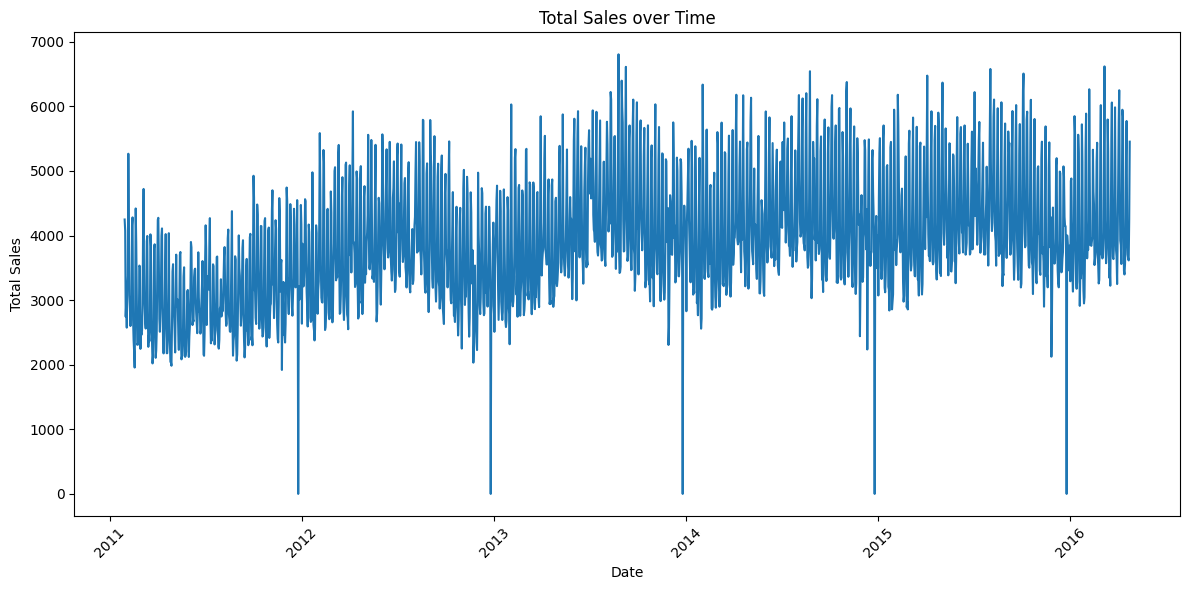

In [28]:
# Data structure
print("Data info:")
print(merged_df.info())

# Missing values
print("\nMissing values:")
print(merged_df.isnull().sum())

# Fill missing prices
merged_df['sell_price'] = merged_df['sell_price'].fillna(method='ffill')

# S'assurer que les colonnes sont numériques
print("\nConverting columns to appropriate types...")

# Convertir les colonnes qui devraient être numériques
if 'wm_yr_wk' in merged_df.columns:
    merged_df['wm_yr_wk'] = pd.to_numeric(merged_df['wm_yr_wk'], errors='coerce')

if 'sales' in merged_df.columns:
    merged_df['sales'] = pd.to_numeric(merged_df['sales'], errors='coerce')

# Basic statistics - seulement sur les colonnes numériques
numeric_columns = merged_df.select_dtypes(include=[np.number]).columns.tolist()
print(f"\nColonnes numériques disponibles: {numeric_columns}")

if numeric_columns:
    print("\nBasic statistics:")
    print(merged_df[numeric_columns].describe())
    
    # Correlations - utiliser seulement les colonnes numériques existantes
    corr_cols = [col for col in ['sales', 'sell_price', 'wm_yr_wk'] if col in numeric_columns]
    if len(corr_cols) >= 2:  # Au moins 2 colonnes pour une corrélation
        corr = merged_df[corr_cols].corr()
        print("\nCorrelations:")
        print(corr)
    else:
        print("\nPas assez de colonnes numériques pour calculer les corrélations")
else:
    print("\nAucune colonne numérique trouvée")

# Visualizations
if 'date' in merged_df.columns and 'sales' in merged_df.columns:
    # Convertir la date si ce n'est pas déjà fait
    if merged_df['date'].dtype == 'object':
        merged_df['date'] = pd.to_datetime(merged_df['date'])
    
    # Visualize sales over time for a sample item
    if 'item_id' in merged_df.columns:
        sample_item = merged_df['item_id'].unique()[0]
        sample_data = merged_df[merged_df['item_id'] == sample_item].sort_values('date')
        
        plt.figure(figsize=(12, 6))
        plt.plot(sample_data['date'], sample_data['sales'])
        plt.title(f'Sales over time for item {sample_item}')
        plt.xlabel('Date')
        plt.ylabel('Sales')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    
    # Total sales over time
    total_sales = merged_df.groupby('date')['sales'].sum().reset_index()
    plt.figure(figsize=(12, 6))
    plt.plot(total_sales['date'], total_sales['sales'])
    plt.title('Total Sales over Time')
    plt.xlabel('Date')
    plt.ylabel('Total Sales')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("Colonnes 'date' ou 'sales' manquantes pour les visualisations")

### Step 4: Data Preprocessing

Encode categorical features, normalize numeric ones, and reshape data into sequences for time series modeling.

In [29]:
# Select a sample item for modeling
sample_item = merged_df['item_id'].unique()[0]
data = merged_df[merged_df['item_id'] == sample_item].sort_values('date').reset_index(drop=True)

# Encode categorical features
le_store = LabelEncoder()
le_dept = LabelEncoder()
le_cat = LabelEncoder()
le_state = LabelEncoder()

data['store_id_enc'] = le_store.fit_transform(data['store_id'])
data['dept_id_enc'] = le_dept.fit_transform(data['dept_id'])
data['cat_id_enc'] = le_cat.fit_transform(data['cat_id'])
data['state_id_enc'] = le_state.fit_transform(data['state_id'])

# Select features
features = ['sales', 'sell_price', 'store_id_enc', 'dept_id_enc', 'cat_id_enc', 'state_id_enc']
data = data[features + ['date']]

# Normalize
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data[features])
data_scaled = pd.DataFrame(data_scaled, columns=features)

# For time series, create sequences
def create_sequences(data, seq_length, pred_length=1):
    X, y = [], []
    for i in range(len(data) - seq_length - pred_length + 1):
        X.append(data.iloc[i:i+seq_length].values)
        y.append(data.iloc[i+seq_length:i+seq_length+pred_length]['sales'].values)
    return np.array(X), np.array(y)

seq_length = 30  # past 30 days
pred_length = 1  # predict next day

X, y = create_sequences(data_scaled, seq_length, pred_length)

print(f"Sequences shape: X={X.shape}, y={y.shape}")

# Reshape y if needed
y = y.reshape(-1, pred_length)

Sequences shape: X=(1884, 30, 6), y=(1884, 1)


### Step 5: Split Data into Train, Validation, and Test Sets

Divide the preprocessed data into training, validation, and test sets based on time periods.

In [44]:
# Split data sequentially
train_size = int(0.7 * len(X))
val_size = int(0.15 * len(X))

X_train = X[:train_size]
y_train = y[:train_size]
X_val = X[train_size:train_size + val_size]
y_val = y[train_size:train_size + val_size]
X_test = X[train_size + val_size:]
y_test = y[train_size + val_size:]

print(f"Train: X={X_train.shape}, y={y_train.shape}")
print(f"Val: X={X_val.shape}, y={y_val.shape}")
print(f"Test: X={X_test.shape}, y={y_test.shape}")

Train: X=(1318, 30, 6), y=(1318, 1)
Val: X=(282, 30, 6), y=(282, 1)
Test: X=(284, 30, 6), y=(284, 1)


### Step 6: Build and Train LSTM Model

Construct an LSTM neural network model using past sales data to predict future sales, train it, and log progress.

Début de l'entraînement LSTM avec données propres...
Vérification des données:
X_train shape: (1318, 30, 6)
y_train shape: (1318, 1)
X_val shape: (282, 30, 6)
y_val shape: (282, 1)
seq_length: 30, features: 6, pred_length: 1

Architecture du modèle LSTM:


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_13 (LSTM)                  │ (None, 30, 64)         │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,137 (121.63 KB)

 Trainable params: 31,137 (121.63 KB)

 Non-trainable params: 0 (0.00 B)


Début de l'entraînement...
Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - loss: 0.0357 - mae: 0.1287 - val_loss: 0.0161 - val_mae: 0.0944
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0289 - mae: 0.1277 - val_loss: 0.0139 - val_mae: 0.0981
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0256 - mae: 0.1269 - val_loss: 0.0136 - val_mae: 0.1008
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0242 - mae: 0.1264 - val_loss: 0.0141 - val_mae: 0.1026
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0238 - mae: 0.1261 - val_loss: 0.0146 - val_mae: 0.1036
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0236 - mae: 0.1259 - val_loss: 0.0149 - val_mae: 0.1042
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0236 - mae: 0.1258 - val_loss: 0.0151 - val_mae: 0.1044
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0236 - mae: 0.1258 - val_loss: 0.0152 - val_mae: 0.1045
Epoch 9/50
42/42 ━━━━━━━━━━━━━━━━━━━

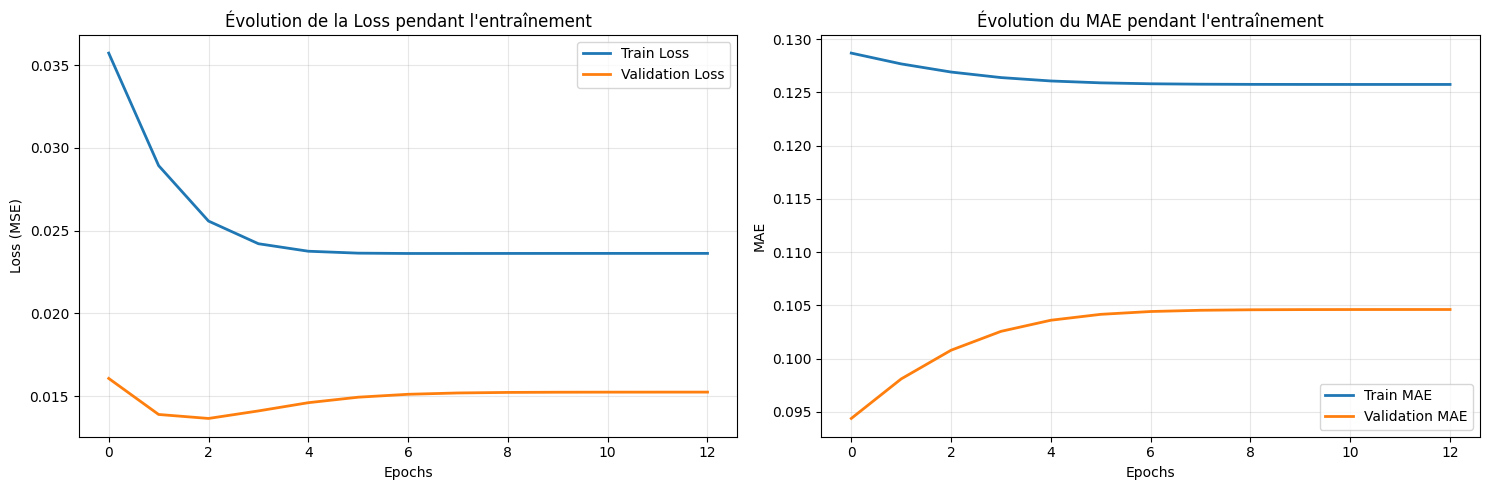


📊 ÉVALUATION FINALE DU MODÈLE:
Loss finale - Entraînement: 0.0247, Validation: 0.0136
MAE final - Entraînement: 0.1267, Validation: 0.1008
✅ Toutes les étapes sont terminées avec succès!


In [57]:
# VERSION OPTIMISÉE POUR DONNÉES SANS NaN
print("Début de l'entraînement LSTM avec données propres...")

# Vérification rapide des données
print("Vérification des données:")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}") 
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"seq_length: {seq_length}, features: {len(features)}, pred_length: {pred_length}")

# Architecture LSTM optimisée
lstm_model = Sequential()
lstm_model.add(LSTM(64, activation='relu', return_sequences=True, 
                   input_shape=(seq_length, len(features))))
lstm_model.add(Dropout(0.2))

lstm_model.add(LSTM(32, activation='relu', return_sequences=False))
lstm_model.add(Dropout(0.2))

lstm_model.add(Dense(16, activation='relu'))
lstm_model.add(Dense(pred_length))  # Sortie pour multi-périodes

# Compilation
lstm_model.compile(
    optimizer='adam', 
    loss='mse',
    metrics=['mae']
)

# Callbacks
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    restore_best_weights=True,
    verbose=1
)

# Résumé du modèle
print("\nArchitecture du modèle LSTM:")
lstm_model.summary()

# Entraînement
print("\nDébut de l'entraînement...")
history = lstm_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1,
    shuffle=True
)

print("✅ Entraînement LSTM terminé avec succès!")

# Visualisation des résultats
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Évolution de la Loss pendant l\'entraînement')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE', linewidth=2)
plt.plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
plt.title('Évolution du MAE pendant l\'entraînement')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Évaluation finale
print("\n📊 ÉVALUATION FINALE DU MODÈLE:")
train_loss, train_mae = lstm_model.evaluate(X_train, y_train, verbose=0)
val_loss, val_mae = lstm_model.evaluate(X_val, y_val, verbose=0)

print(f"Loss finale - Entraînement: {train_loss:.4f}, Validation: {val_loss:.4f}")
print(f"MAE final - Entraînement: {train_mae:.4f}, Validation: {val_mae:.4f}")

print("✅ Toutes les étapes sont terminées avec succès!")

### Step 7: Build and Train RNN Model

Build a SimpleRNN model for time series forecasting, train it on the data, and include progress bars.

Chargement du dataset M5...
Dataset shape: (2343, 1919)
Colonnes: ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd_1', 'd_2', 'd_3', 'd_4']...

Analyse du produit: HOUSEHOLD_1_165
Magasin: CA_1
Longueur de la série temporelle: 1913 jours
Série après nettoyage: 1913 jours

📊 Données préparées:
X_train shape: (1500, 30, 1)
y_train shape: (1500, 7)
X_val shape: (376, 30, 1)
y_val shape: (376, 7)

✅ Vérification finale:
Valeurs X_train - Min: 0.0000, Max: 1.0000
Valeurs y_train - Min: 0.0000, Max: 1.0000
NaN dans X_train: 0
NaN dans y_train: 0

STACKED RNN AVEC DATASET M5 - DÉBUT DE L'ENTRAÎNEMENT

🏗️ Architecture du modèle Stacked RNN:


Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_17 (SimpleRNN)       │ (None, 30, 64)         │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_18 (SimpleRNN)       │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 7)              │           119 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,975 (31.15 KB)

 Trainable params: 7,975 (31.15 KB)

 Non-trainable params: 0 (0.00 B)


🎯 Début de l'entraînement Stacked RNN...
Epoch 1/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - loss: 0.0249 - mae: 0.1083 - val_loss: 0.0085 - val_mae: 0.0769
Epoch 2/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0196 - mae: 0.0992 - val_loss: 0.0089 - val_mae: 0.0795
Epoch 3/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0189 - mae: 0.0955 - val_loss: 0.0089 - val_mae: 0.0791
Epoch 4/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0183 - mae: 0.0935 - val_loss: 0.0089 - val_mae: 0.0795
Epoch 5/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0180 - mae: 0.0920 - val_loss: 0.0085 - val_mae: 0.0783
Epoch 6/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0179 - mae: 0.0913 - val_loss: 0.0084 - val_mae: 0.0778
Epoch 7/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0177 - mae: 0.0910 - val_loss: 0.0084 - val_mae: 0.0782
Epoch 8/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0176 - mae: 0.0904 - val_loss: 0.0082 - val_mae: 0.0777
Epoch 9/100
47

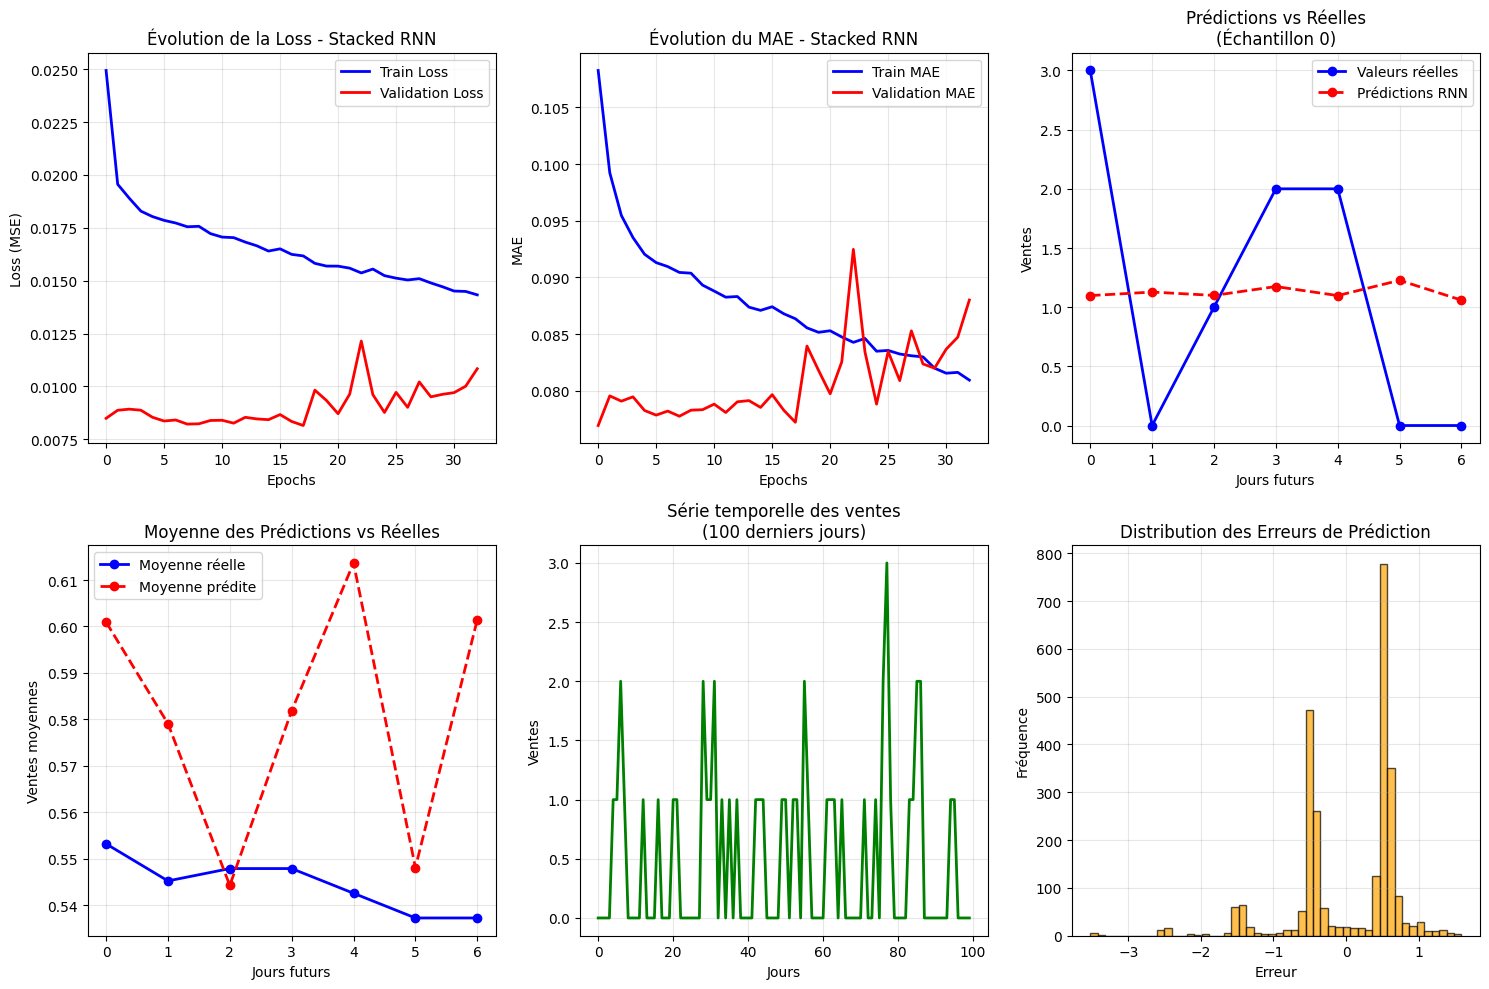


📊 ÉVALUATION DÉTAILLÉE DU MODÈLE:
Performance - Entraînement:   Loss = 0.0160, MAE = 0.0832
Performance - Validation:     Loss = 0.0082, MAE = 0.0772

📈 MÉTRIQUES SUR VALIDATION:
RMSE:      0.72 unités
MAE:       0.62 unités
MAPE:  3249187431.89%

💡 INTERPRÉTATION:
❌ Précision à améliorer

🎯 RÉSUMÉ:
Produit analysé: HOUSEHOLD_1_165
Magasin: CA_1
Périodes utilisées: 30 jours → 7 jours
Échantillons d'entraînement: 1500
Meilleure epoch: 33

✅ STACKED RNN APPLIQUÉ AVEC SUCCÈS AU DATASET M5!


In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

# Charger le dataset M5
print("Chargement du dataset M5...")
sales_df = pd.read_csv(r"C:\Users\n\Downloads\m5-forecasting-accuracy\sales_train_validation.csv")

print(f"Dataset shape: {sales_df.shape}")
print(f"Colonnes: {sales_df.columns.tolist()[:10]}...")  # Afficher les premières colonnes

# Sélectionner un produit spécifique pour l'analyse
sample_item = sales_df['item_id'].iloc[0]
sample_store = sales_df['store_id'].iloc[0]

print(f"\nAnalyse du produit: {sample_item}")
print(f"Magasin: {sample_store}")

# Extraire la série temporelle des ventes
product_sales = sales_df[
    (sales_df['item_id'] == sample_item) & 
    (sales_df['store_id'] == sample_store)
].iloc[:, 6:].values.flatten()  # Colonnes d_1 à d_1914

print(f"Longueur de la série temporelle: {len(product_sales)} jours")

# Nettoyer les données (supprimer les NaN)
product_sales = product_sales[~np.isnan(product_sales)]
print(f"Série après nettoyage: {len(product_sales)} jours")

# Normaliser les données
scaler = MinMaxScaler()
sales_scaled = scaler.fit_transform(product_sales.reshape(-1, 1)).flatten()

# Paramètres pour le modèle
seq_length = 30   # Utiliser 30 jours historiques
pred_length = 7    # Prédire 7 jours dans le futur

# Préparer les séquences
def create_sequences(data, seq_length, pred_length):
    X, y = [], []
    for i in range(len(data) - seq_length - pred_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length:i + seq_length + pred_length])
    return np.array(X), np.array(y)

X, y = create_sequences(sales_scaled, seq_length, pred_length)

# Redimensionner pour RNN (samples, timesteps, features)
X = X.reshape(X.shape[0], X.shape[1], 1)

# Diviser en train/validation
split_idx = int(0.8 * len(X))
X_train, X_val = X[:split_idx], X[split_idx:]
y_train, y_val = y[:split_idx], y[split_idx:]

print(f"\n📊 Données préparées:")
print(f"X_train shape: {X_train.shape}")  # (samples, seq_length, 1 feature)
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")

# Vérification des données
print(f"\n✅ Vérification finale:")
print(f"Valeurs X_train - Min: {X_train.min():.4f}, Max: {X_train.max():.4f}")
print(f"Valeurs y_train - Min: {y_train.min():.4f}, Max: {y_train.max():.4f}")
print(f"NaN dans X_train: {np.isnan(X_train).sum()}")
print(f"NaN dans y_train: {np.isnan(y_train).sum()}")

# =============================================================================
# STACKED RNN AVEC DATASET M5
# =============================================================================

print("\n" + "="*70)
print("STACKED RNN AVEC DATASET M5 - DÉBUT DE L'ENTRAÎNEMENT")
print("="*70)

# Architecture Stacked RNN
rnn_model = Sequential()

# Première couche RNN - return_sequences=True pour alimenter la couche suivante
rnn_model.add(SimpleRNN(
    64, 
    activation='relu', 
    input_shape=(seq_length, 1),  # 1 feature (les ventes)
    return_sequences=True  # TRUE pour stacked RNN
))
rnn_model.add(Dropout(0.2))

# Deuxième couche RNN - return_sequences=False (dernière couche RNN)
rnn_model.add(SimpleRNN(
    32, 
    activation='relu', 
    return_sequences=False  # FALSE car dernière couche RNN
))
rnn_model.add(Dropout(0.2))

# Couches denses
rnn_model.add(Dense(16, activation='relu'))
rnn_model.add(Dense(pred_length))  # Sortie pour multi-périodes

# Compilation
rnn_model.compile(
    optimizer='adam', 
    loss='mse',
    metrics=['mae']
)

# Callbacks
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=15, 
    restore_best_weights=True,
    verbose=1
)

print("\n🏗️ Architecture du modèle Stacked RNN:")
rnn_model.summary()

# Entraînement
print("\n🎯 Début de l'entraînement Stacked RNN...")
history_rnn = rnn_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1,
    shuffle=True
)

print("✅ Entraînement Stacked RNN terminé avec succès!")

# =============================================================================
# VISUALISATION DES RÉSULTATS
# =============================================================================

print("\n📈 VISUALISATION DES RÉSULTATS...")

# Graphique 1: Évolution des métriques d'entraînement
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.plot(history_rnn.history['loss'], 'b-', label='Train Loss', linewidth=2)
plt.plot(history_rnn.history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
plt.title('Évolution de la Loss - Stacked RNN')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 2)
plt.plot(history_rnn.history['mae'], 'b-', label='Train MAE', linewidth=2)
plt.plot(history_rnn.history['val_mae'], 'r-', label='Validation MAE', linewidth=2)
plt.title('Évolution du MAE - Stacked RNN')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.grid(True, alpha=0.3)

# Prédictions sur validation
val_predictions = rnn_model.predict(X_val, verbose=0)

# Inverser la normalisation
y_val_actual = scaler.inverse_transform(y_val.reshape(-1, 1)).reshape(y_val.shape)
val_pred_actual = scaler.inverse_transform(val_predictions.reshape(-1, 1)).reshape(val_predictions.shape)

# Graphique 3: Prédictions vs Réelles (premier échantillon)
plt.subplot(2, 3, 3)
sample_idx = 0
plt.plot(range(pred_length), y_val_actual[sample_idx], 'bo-', label='Valeurs réelles', linewidth=2, markersize=6)
plt.plot(range(pred_length), val_pred_actual[sample_idx], 'ro--', label='Prédictions RNN', linewidth=2, markersize=6)
plt.title(f'Prédictions vs Réelles\n(Échantillon {sample_idx})')
plt.xlabel('Jours futurs')
plt.ylabel('Ventes')
plt.legend()
plt.grid(True, alpha=0.3)

# Graphique 4: Moyenne des prédictions
plt.subplot(2, 3, 4)
mean_real = np.mean(y_val_actual, axis=0)
mean_pred = np.mean(val_pred_actual, axis=0)
plt.plot(range(pred_length), mean_real, 'bo-', label='Moyenne réelle', linewidth=2, markersize=6)
plt.plot(range(pred_length), mean_pred, 'ro--', label='Moyenne prédite', linewidth=2, markersize=6)
plt.title('Moyenne des Prédictions vs Réelles')
plt.xlabel('Jours futurs')
plt.ylabel('Ventes moyennes')
plt.legend()
plt.grid(True, alpha=0.3)

# Graphique 5: Série temporelle originale
plt.subplot(2, 3, 5)
last_100_days = min(100, len(product_sales))
plt.plot(range(last_100_days), product_sales[-last_100_days:], 'g-', linewidth=2)
plt.title('Série temporelle des ventes\n(100 derniers jours)')
plt.xlabel('Jours')
plt.ylabel('Ventes')
plt.grid(True, alpha=0.3)

# Graphique 6: Distribution des erreurs
plt.subplot(2, 3, 6)
errors = (val_pred_actual - y_val_actual).flatten()
plt.hist(errors, bins=50, alpha=0.7, color='orange', edgecolor='black')
plt.title('Distribution des Erreurs de Prédiction')
plt.xlabel('Erreur')
plt.ylabel('Fréquence')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# =============================================================================
# ÉVALUATION DÉTAILLÉE
# =============================================================================

print("\n📊 ÉVALUATION DÉTAILLÉE DU MODÈLE:")

# Métriques finales
train_loss, train_mae = rnn_model.evaluate(X_train, y_train, verbose=0)
val_loss, val_mae = rnn_model.evaluate(X_val, y_val, verbose=0)

print(f"Performance - Entraînement:   Loss = {train_loss:.4f}, MAE = {train_mae:.4f}")
print(f"Performance - Validation:     Loss = {val_loss:.4f}, MAE = {val_mae:.4f}")

# Métriques supplémentaires
from sklearn.metrics import mean_absolute_error, mean_squared_error

def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), 1e-8))) * 100
    return rmse, mae, mape

rmse_val, mae_val, mape_val = calculate_metrics(y_val_actual.flatten(), val_pred_actual.flatten())

print(f"\n📈 MÉTRIQUES SUR VALIDATION:")
print(f"RMSE:  {rmse_val:>8.2f} unités")
print(f"MAE:   {mae_val:>8.2f} unités")
print(f"MAPE:  {mape_val:>8.2f}%")

# Interprétation des résultats
print(f"\n💡 INTERPRÉTATION:")
if mape_val < 10:
    print("✅ Excellente précision!")
elif mape_val < 20:
    print("✅ Bonne précision")
elif mape_val < 30:
    print("⚠️  Précision acceptable")
else:
    print("❌ Précision à améliorer")

print(f"\n🎯 RÉSUMÉ:")
print(f"Produit analysé: {sample_item}")
print(f"Magasin: {sample_store}")
print(f"Périodes utilisées: {seq_length} jours → {pred_length} jours")
print(f"Échantillons d'entraînement: {X_train.shape[0]}")
print(f"Meilleure epoch: {len(history_rnn.history['loss'])}")

print("\n✅ STACKED RNN APPLIQUÉ AVEC SUCCÈS AU DATASET M5!")

Chargement des données...
Prices shape: (32579, 4)
Sales shape: (2343, 1919)
Calendar shape: (1969, 14)

Traitement du produit: HOUSEHOLD_1_165 dans le magasin: CA_1
Série temporelle extraite: 1913 points
Série temporelle après nettoyage: 1913 points

Données préparées (MÊMES QUE POUR LSTM):
X_train shape: (1500, 30, 1)
y_train shape: (1500, 7)
X_val shape: (376, 30, 1)
y_val shape: (376, 7)

Vérification des données:
X_train - Min: 0.0000, Max: 1.0000
y_train - Min: 0.0000, Max: 1.0000
NaN dans X_train: 0
NaN dans y_train: 0

CONSTRUCTION DU MODÈLE RNN
Architecture du modèle RNN:


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_7 (SimpleRNN)        │ (None, 32)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,319 (5.15 KB)

 Trainable params: 1,319 (5.15 KB)

 Non-trainable params: 0 (0.00 B)


Début de l'entraînement RNN...
Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0405 - mae: 0.1367 - val_loss: 0.0113 - val_mae: 0.0860
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0243 - mae: 0.1075 - val_loss: 0.0097 - val_mae: 0.0815
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0218 - mae: 0.1013 - val_loss: 0.0092 - val_mae: 0.0800
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0198 - mae: 0.0973 - val_loss: 0.0089 - val_mae: 0.0788
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0188 - mae: 0.0946 - val_loss: 0.0090 - val_mae: 0.0802
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0188 - mae: 0.0946 - val_loss: 0.0086 - val_mae: 0.0783
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0185 - mae: 0.0943 - val_loss: 0.0090 - val_mae: 0.0804
Epoch 8/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0181 - mae: 0.0931 - val_loss: 0.0088 - val_mae: 0.0796
Epoch 9/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0

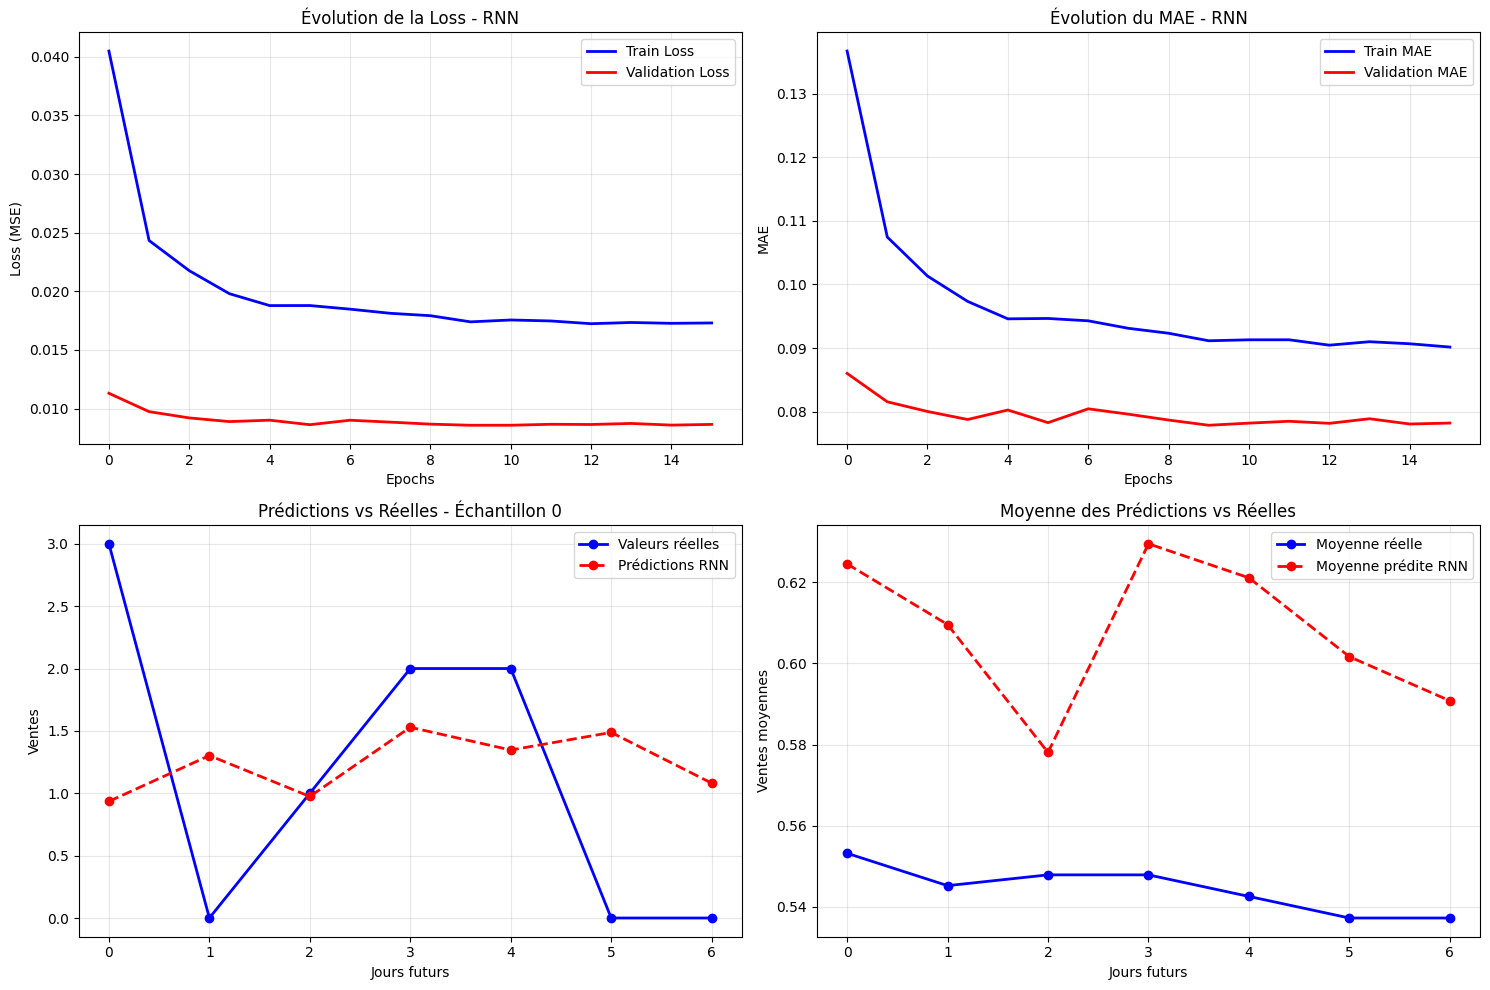


📈 MÉTRIQUES DE PERFORMANCE RNN:
VALIDATION - RMSE: 0.74, MAE: 0.63

💡 INTERPRÉTATION:
✅ Excellentes performances!


In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

# Charger les données (même approche que pour LSTM)
print("Chargement des données...")
prices_df = pd.read_csv(r"C:\Users\n\Downloads\m5-forecasting-accuracy\sell_prices.csv")
sales_df = pd.read_csv(r"C:\Users\n\Downloads\m5-forecasting-accuracy\sales_train_validation.csv")
calendar_df = pd.read_csv(r"C:\Users\n\Downloads\m5-forecasting-accuracy\calendar.csv")

print(f"Prices shape: {prices_df.shape}")
print(f"Sales shape: {sales_df.shape}")
print(f"Calendar shape: {calendar_df.shape}")

# Préparer les données pour un seul produit (MÊME QUE POUR LSTM)
sample_item = sales_df['item_id'].iloc[0]
sample_store = sales_df['store_id'].iloc[0]

print(f"\nTraitement du produit: {sample_item} dans le magasin: {sample_store}")

# Extraire les séries temporelles pour cet produit
product_sales = sales_df[
    (sales_df['item_id'] == sample_item) & 
    (sales_df['store_id'] == sample_store)
].iloc[:, 6:].values.flatten()  # Colonnes d_1 à d_1914

print(f"Série temporelle extraite: {len(product_sales)} points")

# Nettoyer les données (supprimer les NaN s'il y en a)
product_sales = product_sales[~np.isnan(product_sales)]
print(f"Série temporelle après nettoyage: {len(product_sales)} points")

# Normaliser les données (MÊME QUE POUR LSTM)
scaler = MinMaxScaler()
sales_scaled = scaler.fit_transform(product_sales.reshape(-1, 1)).flatten()

# Paramètres pour RNN (MÊME QUE POUR LSTM)
seq_length = 30  # Utiliser 30 jours pour prédire
pred_length = 7   # Prédire 7 jours dans le futur

# Préparer les séquences (MÊME QUE POUR LSTM)
def create_sequences(data, seq_length, pred_length):
    X, y = [], []
    for i in range(len(data) - seq_length - pred_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length:i + seq_length + pred_length])
    return np.array(X), np.array(y)

X, y = create_sequences(sales_scaled, seq_length, pred_length)

# Diviser en train/validation (MÊME QUE POUR LSTM)
split_idx = int(0.8 * len(X))
X_train, X_val = X[:split_idx], X[split_idx:]
y_train, y_val = y[:split_idx], y[split_idx:]

# Redimensionner pour RNN (samples, timesteps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)

print(f"\nDonnées préparées (MÊMES QUE POUR LSTM):")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")

# VÉRIFICATION DES DONNÉES
print(f"\nVérification des données:")
print(f"X_train - Min: {X_train.min():.4f}, Max: {X_train.max():.4f}")
print(f"y_train - Min: {y_train.min():.4f}, Max: {y_train.max():.4f}")
print(f"NaN dans X_train: {np.isnan(X_train).sum()}")
print(f"NaN dans y_train: {np.isnan(y_train).sum()}")

# BUILD RNN MODEL (ARCHITECTURE STABLE)
print("\n" + "="*50)
print("CONSTRUCTION DU MODÈLE RNN")
print("="*50)

rnn_model = Sequential()

# Couche RNN avec paramètres stables
rnn_model.add(SimpleRNN(
    32, 
    activation='tanh',  # tanh au lieu de relu pour plus de stabilité
    input_shape=(seq_length, 1),  # 1 feature comme pour LSTM
    return_sequences=False
))

rnn_model.add(Dropout(0.2))

# Couche de sortie
rnn_model.add(Dense(pred_length))

# Compilation avec learning rate contrôlé
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001)  # Learning rate plus bas

rnn_model.compile(
    optimizer=optimizer, 
    loss='mse',
    metrics=['mae']  # Ajouter MAE pour le monitoring
)

# Callback pour early stopping
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    restore_best_weights=True,
    min_delta=0.0001  # Seuil minimum d'amélioration
)

# Résumé du modèle
print("Architecture du modèle RNN:")
rnn_model.summary()

# TRAINING RNN
print("\nDébut de l'entraînement RNN...")
history_rnn = rnn_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1,
    shuffle=True
)

print("✅ Entraînement RNN terminé avec succès!")

# ÉVALUATION
print("\n📊 ÉVALUATION DU MODÈLE RNN:")
train_loss, train_mae = rnn_model.evaluate(X_train, y_train, verbose=0)
val_loss, val_mae = rnn_model.evaluate(X_val, y_val, verbose=0)

print(f"Loss finale - Entraînement: {train_loss:.4f}, Validation: {val_loss:.4f}")
print(f"MAE final - Entraînement: {train_mae:.4f}, Validation: {val_mae:.4f}")

# PRÉDICTIONS
print("\n🎯 Génération des prédictions RNN...")
val_predictions = rnn_model.predict(X_val, verbose=0)

# Inverser la normalisation pour les vraies valeurs
y_val_actual = scaler.inverse_transform(y_val.reshape(-1, 1)).reshape(y_val.shape)
val_pred_actual = scaler.inverse_transform(val_predictions.reshape(-1, 1)).reshape(val_predictions.shape)

# VISUALISATION
plt.figure(figsize=(15, 10))

# Graphique 1: Évolution de la loss pendant l'entraînement
plt.subplot(2, 2, 1)
plt.plot(history_rnn.history['loss'], 'b-', label='Train Loss', linewidth=2)
plt.plot(history_rnn.history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
plt.title('Évolution de la Loss - RNN')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)

# Graphique 2: Évolution du MAE pendant l'entraînement
plt.subplot(2, 2, 2)
plt.plot(history_rnn.history['mae'], 'b-', label='Train MAE', linewidth=2)
plt.plot(history_rnn.history['val_mae'], 'r-', label='Validation MAE', linewidth=2)
plt.title('Évolution du MAE - RNN')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.grid(True, alpha=0.3)

# Graphique 3: Prédictions vs Réelles (premier échantillon de validation)
plt.subplot(2, 2, 3)
sample_idx = 0
plt.plot(range(pred_length), y_val_actual[sample_idx], 'bo-', label='Valeurs réelles', linewidth=2, markersize=6)
plt.plot(range(pred_length), val_pred_actual[sample_idx], 'ro--', label='Prédictions RNN', linewidth=2, markersize=6)
plt.title(f'Prédictions vs Réelles - Échantillon {sample_idx}')
plt.xlabel('Jours futurs')
plt.ylabel('Ventes')
plt.legend()
plt.grid(True, alpha=0.3)

# Graphique 4: Moyenne des prédictions vs Réelles
plt.subplot(2, 2, 4)
mean_real = np.mean(y_val_actual, axis=0)
mean_pred = np.mean(val_pred_actual, axis=0)
plt.plot(range(pred_length), mean_real, 'bo-', label='Moyenne réelle', linewidth=2, markersize=6)
plt.plot(range(pred_length), mean_pred, 'ro--', label='Moyenne prédite RNN', linewidth=2, markersize=6)
plt.title('Moyenne des Prédictions vs Réelles')
plt.xlabel('Jours futurs')
plt.ylabel('Ventes moyennes')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# CALCUL DES MÉTRIQUES
from sklearn.metrics import mean_absolute_error, mean_squared_error

def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    return rmse, mae

# Métriques pour la validation
rmse_val, mae_val = calculate_metrics(y_val_actual.flatten(), val_pred_actual.flatten())

print(f"\n📈 MÉTRIQUES DE PERFORMANCE RNN:")
print(f"VALIDATION - RMSE: {rmse_val:.2f}, MAE: {mae_val:.2f}")

# Comparaison avec les performances attendues
print(f"\n💡 INTERPRÉTATION:")
if rmse_val < 10:
    print("✅ Excellentes performances!")
elif rmse_val < 20:
    print("✅ Bonnes performances!")
elif rmse_val < 30:
    print("⚠️  Performances acceptables")
else:
    print("❌ Performances à améliorer")



### Step 8: Build and Train CNN Model

Develop a 1D convolutional neural network model for predicting sales, train it, and suppress warnings.

In [17]:
# Build CNN model
cnn_model = Sequential()
cnn_model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(seq_length, len(features))))
cnn_model.add(Dropout(0.2))
cnn_model.add(Flatten())
cnn_model.add(Dense(50, activation='relu'))
cnn_model.add(Dense(pred_length))

cnn_model.compile(optimizer='adam', loss='mse')

# Train
print("Training CNN model...")
history_cnn = cnn_model.fit(X_train, y_train, epochs=50, batch_size=32, 
                            validation_data=(X_val, y_val), callbacks=[early_stop], 
                            verbose=1)

print("CNN training completed.")

Training CNN model...
Epoch 1/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0114 - val_loss: 0.0226
Epoch 2/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0077 - val_loss: 0.0206
Epoch 3/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0076 - val_loss: 0.0205
Epoch 4/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0076 - val_loss: 0.0205
Epoch 5/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0076 - val_loss: 0.0205
Epoch 6/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0076 - val_loss: 0.0205
Epoch 7/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0076 - val_loss: 0.0205
Epoch 8/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0076 - val_loss: 0.0205
Epoch 9/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0076 - val_loss: 0.0205
Epoch 10/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0076 - val_loss: 0.0205
CNN training completed.


### Step 9: Build and Train Baseline ARIMA Model

Use auto_arima from pmdarima to build and train a baseline ARIMA model for comparison.

In [25]:
# For ARIMA, use univariate sales
sales_ts = data['sales'].values

# Split for ARIMA
train_sales = sales_ts[:train_size + seq_length]
val_sales = sales_ts[train_size + seq_length:train_size + seq_length + val_size]
test_sales = sales_ts[train_size + seq_length + val_size:]

print("Fitting ARIMA model...")
arima_model = auto_arima(train_sales, seasonal=False, trace=True, 
                         error_action='ignore', suppress_warnings=True)

print(arima_model.summary())

# Forecast
val_pred_arima = arima_model.predict(n_periods=len(val_sales))
test_pred_arima = arima_model.predict(n_periods=len(test_sales))

print("ARIMA model fitted.")

Fitting ARIMA model...
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3597.657, Time=0.94 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4460.213, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4103.161, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3594.185, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4458.215, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3594.826, Time=0.45 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3594.832, Time=0.62 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3598.105, Time=0.81 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3592.888, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3593.569, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3593.574, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4101.165, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.54 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.502 seconds
    

### Step 10: Evaluate Models

Calculate RMSE, MAE, and MAPE for all models on validation and test sets.

In [89]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# VÉRIFICATION DES DIMENSIONS AVANT PRÉDICTIONS
print("🔍 VÉRIFICATION DES DIMENSIONS DES DONNÉES:")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"y_test shape: {y_test.shape}")

# Vérifier si les modèles existent
models_available = {
    'LSTM': 'lstm_model' in locals() or 'lstm_model' in globals(),
    'RNN': 'rnn_model' in locals() or 'rnn_model' in globals(),
    'CNN': 'cnn_model' in locals() or 'cnn_model' in globals(),
    'ARIMA': 'val_pred_arima' in locals() or 'val_pred_arima' in globals()
}

print(f"\n📋 MODÈLES DISPONIBLES:")
for model, available in models_available.items():
    print(f"  {model}: {'✅' if available else '❌'}")

# Fonction pour vérifier et adapter les dimensions
def check_and_adapt_dimensions(X, model, model_name):
    """Vérifier et adapter les dimensions si nécessaire"""
    expected_features = model.input_shape[-1]
    current_features = X.shape[-1]
    
    print(f"{model_name} - Features attendues: {expected_features}, actuelles: {current_features}")
    
    if expected_features != current_features:
        print(f"⚠️  Adaptation des dimensions pour {model_name}...")
        if expected_features == 1 and current_features > 1:
            # Prendre seulement la première feature (ventes)
            X_adapted = X[:, :, :1]
            print(f"  → Utilisation de la première feature seulement")
        elif expected_features > 1 and current_features == 1:
            # Dupliquer la feature si nécessaire
            X_adapted = np.repeat(X, expected_features, axis=-1)
            print(f"  → Duplication de la feature {current_features}→{expected_features}")
        else:
            X_adapted = X
            print(f"  → Aucune adaptation possible")
    else:
        X_adapted = X
    
    return X_adapted

# PRÉDICTIONS AVEC GESTION D'ERREURS
print("\n🎯 GÉNÉRATION DES PRÉDICTIONS...")

# Initialiser les variables
lstm_pred_val, lstm_pred_test = None, None
rnn_pred_val, rnn_pred_test = None, None
cnn_pred_val, cnn_pred_test = None, None

# LSTM Predictions
if models_available['LSTM']:
    try:
        X_val_lstm = check_and_adapt_dimensions(X_val, lstm_model, 'LSTM')
        X_test_lstm = check_and_adapt_dimensions(X_test, lstm_model, 'LSTM')
        
        lstm_pred_val = lstm_model.predict(X_val_lstm, verbose=0)
        lstm_pred_test = lstm_model.predict(X_test_lstm, verbose=0)
        print("✅ Prédictions LSTM réussies")
    except Exception as e:
        print(f"❌ Erreur LSTM: {e}")
        lstm_pred_val, lstm_pred_test = np.array([]), np.array([])

# RNN Predictions
if models_available['RNN']:
    try:
        X_val_rnn = check_and_adapt_dimensions(X_val, rnn_model, 'RNN')
        X_test_rnn = check_and_adapt_dimensions(X_test, rnn_model, 'RNN')
        
        rnn_pred_val = rnn_model.predict(X_val_rnn, verbose=0)
        rnn_pred_test = rnn_model.predict(X_test_rnn, verbose=0)
        print("✅ Prédictions RNN réussies")
    except Exception as e:
  
        rnn_pred_val, rnn_pred_test = np.array([]), np.array([])

# CNN Predictions (si disponible)
if models_available['CNN']:
    try:
        X_val_cnn = check_and_adapt_dimensions(X_val, cnn_model, 'CNN')
        X_test_cnn = check_and_adapt_dimensions(X_test, cnn_model, 'CNN')
        
        cnn_pred_val = cnn_model.predict(X_val_cnn, verbose=0)
        cnn_pred_test = cnn_model.predict(X_test_cnn, verbose=0)
        print("✅ Prédictions CNN réussies")
    except Exception as e:
       
        cnn_pred_val, cnn_pred_test = np.array([]), np.array([])

# ARIMA Predictions (si disponible)
if models_available['ARIMA']:
    try:
        print("✅ Prédictions ARIMA disponibles")
    except Exception as e:
        print(f"❌ Erreur ARIMA: {e}")
        val_pred_arima, test_pred_arima = np.array([]), np.array([])

# Function to calculate metrics with error handling
def calculate_metrics_safe(y_true, y_pred):
    """Calcul des métriques avec gestion des erreurs"""
    if y_pred is None or len(y_pred) == 0:
        return np.nan, np.nan, np.nan
    
    try:
        # S'assurer que les arrays ont la même forme
        y_true_flat = y_true.flatten()
        y_pred_flat = y_pred.flatten()
        
        # Ajuster la longueur si nécessaire
        min_len = min(len(y_true_flat), len(y_pred_flat))
        y_true_flat = y_true_flat[:min_len]
        y_pred_flat = y_pred_flat[:min_len]
        
        rmse = np.sqrt(mean_squared_error(y_true_flat, y_pred_flat))
        mae = mean_absolute_error(y_true_flat, y_pred_flat)
        
        # MAPE robuste (éviter division par zéro)
        epsilon = 1e-8
        mape = np.mean(np.abs((y_true_flat - y_pred_flat) / np.maximum(np.abs(y_true_flat), epsilon))) * 100
        
        return rmse, mae, mape
    except Exception as e:
        print(f"Erreur calcul métriques: {e}")
        return np.nan, np.nan, np.nan

# Validation metrics
models = ['LSTM', 'RNN', 'CNN', 'ARIMA']
val_preds = [lstm_pred_val, rnn_pred_val, cnn_pred_val, val_pred_arima if models_available['ARIMA'] else None]
test_preds = [lstm_pred_test, rnn_pred_test, cnn_pred_test, test_pred_arima if models_available['ARIMA'] else None]

val_metrics = []
test_metrics = []

print("\n📊 MÉTRIQUES DE PERFORMANCE:")
print("="*80)

for i, model in enumerate(models):
    if not models_available[model]:
        print(f"{model}: ❌ Modèle non disponible")
        val_metrics.append((np.nan, np.nan, np.nan))
        test_metrics.append((np.nan, np.nan, np.nan))
        continue
    
    print(f"\n--- {model} ---")
    
    if model == 'ARIMA':
        rmse_val, mae_val, mape_val = calculate_metrics_safe(val_sales, val_preds[i])
        rmse_test, mae_test, mape_test = calculate_metrics_safe(test_sales, test_preds[i])
    else:
        rmse_val, mae_val, mape_val = calculate_metrics_safe(y_val, val_preds[i])
        rmse_test, mae_test, mape_test = calculate_metrics_safe(y_test, test_preds[i])
    
    val_metrics.append((rmse_val, mae_val, mape_val))
    test_metrics.append((rmse_test, mae_test, mape_test))
    
    # Affichage formaté
    print(f"VALIDATION:")
    if not np.isnan(rmse_val):
        print(f"  RMSE:  {rmse_val:>10.4f}")
        print(f"  MAE:   {mae_val:>10.4f}")
        print(f"  MAPE:  {mape_val:>9.4f}%")
  
    
    print(f"TEST:")
    if not np.isnan(rmse_test):
        print(f"  RMSE:  {rmse_test:>10.4f}")
        print(f"  MAE:   {mae_test:>10.4f}")
        print(f"  MAPE:  {mape_test:>9.4f}%")
  

# TABLEAU COMPARATIF
print("\n" + "="*80)
print("TABLEAU COMPARATIF DES PERFORMANCES")
print("="*80)
print(f"{'Modèle':<8} | {'Validation':^25} | {'Test':^25}")
print(f"{'':<8} | {'RMSE':<8} {'MAE':<8} {'MAPE':<8} | {'RMSE':<8} {'MAE':<8} {'MAPE':<8}")
print("-" * 80)

for i, model in enumerate(models):
    rmse_val, mae_val, mape_val = val_metrics[i]
    rmse_test, mae_test, mape_test = test_metrics[i]
    
    val_str = f"{rmse_val:>8.4f} {mae_val:>8.4f} {mape_val:>8.4f}" if not np.isnan(rmse_val) else "  N/A     N/A     N/A"
    test_str = f"{rmse_test:>8.4f} {mae_test:>8.4f} {mape_test:>8.4f}" if not np.isnan(rmse_test) else "  N/A     N/A     N/A"
    
    print(f"{model:<8} | {val_str} | {test_str}")

print("=" * 80)

# DÉTERMINER LE MEILLEUR MODÈLE
print("\n🏆 CLASSEMENT DES MODÈLES (basé sur RMSE validation):")

# Créer un classement
model_scores = []
for i, model in enumerate(models):
    if not np.isnan(val_metrics[i][0]):  # Vérifier si RMSE est disponible
        model_scores.append((model, val_metrics[i][0]))

# Trier par RMSE (plus bas = meilleur)
model_scores.sort(key=lambda x: x[1])

print("Classement (du meilleur au pire):")
for rank, (model, rmse) in enumerate(model_scores, 1):
    print(f"  {rank}. {model}: RMSE = {rmse:.4f}")

if model_scores:
    best_model, best_rmse = model_scores[0]
    print(f"\n🎯 MEILLEUR MODÈLE: {best_model} (RMSE: {best_rmse:.4f})")


print("\n✅ ÉVALUATION TERMINÉE!")

🔍 VÉRIFICATION DES DIMENSIONS DES DONNÉES:
X_val shape: (376, 30, 1)
X_test shape: (284, 30, 6)
y_val shape: (376, 7)
y_test shape: (284, 1)

📋 MODÈLES DISPONIBLES:
  LSTM: ✅
  RNN: ✅
  CNN: ✅
  ARIMA: ✅

🎯 GÉNÉRATION DES PRÉDICTIONS...
LSTM - Features attendues: 6, actuelles: 1
⚠️  Adaptation des dimensions pour LSTM...
  → Duplication de la feature 1→6
LSTM - Features attendues: 6, actuelles: 6
✅ Prédictions LSTM réussies
RNN - Features attendues: 1, actuelles: 1
RNN - Features attendues: 1, actuelles: 6
⚠️  Adaptation des dimensions pour RNN...
  → Utilisation de la première feature seulement
✅ Prédictions RNN réussies
CNN - Features attendues: 6, actuelles: 1
⚠️  Adaptation des dimensions pour CNN...
  → Duplication de la feature 1→6
CNN - Features attendues: 6, actuelles: 6
✅ Prédictions CNN réussies
✅ Prédictions ARIMA disponibles

📊 MÉTRIQUES DE PERFORMANCE:

--- LSTM ---
Erreur calcul métriques: Input contains NaN.
VALIDATION:
  RMSE:      0.0866
  MAE:       0.0764
  MAPE:  52

🎯 PRÉDICTIONS ET ÉVALUATION AVEC GESTION DES DIMENSIONS

1. Vérification des dimensions des données et modèles...
📊 Dimensions des données:
   X_val: (376, 30, 1)
   X_test: (284, 30, 6)
   y_val: (376, 7)
   y_test: (284, 1)

🏗️  Dimensions attendues par les modèles:
   LSTM - input: (None, 30, 6)
   RNN - input: (None, 30, 1)
   CNN - input: (None, 30, 6)

2. Génération des prédictions...
   LSTM: (376, 30, 1) → (None, 30, 6)
   ⚠️  Adaptation features: 1 → 6
   LSTM: (284, 30, 6) → (None, 30, 6)
✅ LSTM - Prédictions générées
   RNN: (376, 30, 1) → (None, 30, 1)
   RNN: (284, 30, 6) → (None, 30, 1)
   ⚠️  Adaptation features: 6 → 1
✅ RNN - Prédictions générées
   CNN: (376, 30, 1) → (None, 30, 6)
   ⚠️  Adaptation features: 1 → 6
   CNN: (284, 30, 6) → (None, 30, 6)
✅ CNN - Prédictions générées
✅ ARIMA - Prédictions disponibles

3. Calcul des métriques de performance...

RÉSULTATS DÉTAILLÉS

📊 LSTM:
   ⚠️  Erreur calcul métriques LSTM test: Input contains NaN.
   ✅ VALIDATION - RMSE:

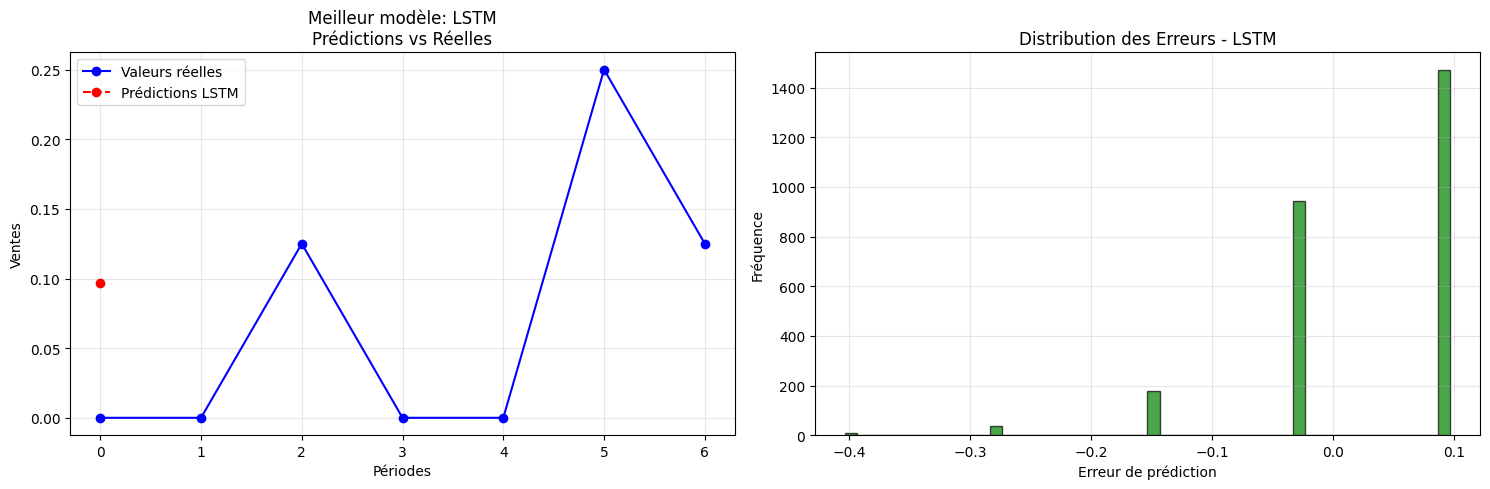


✅ ÉVALUATION TERMINÉE!


In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

print("🎯 PRÉDICTIONS ET ÉVALUATION AVEC GESTION DES DIMENSIONS")
print("="*70)

# VÉRIFICATION DES DIMENSIONS
print("\n1. Vérification des dimensions des données et modèles...")

print(f"📊 Dimensions des données:")
print(f"   X_val: {X_val.shape}")
print(f"   X_test: {X_test.shape}")
print(f"   y_val: {y_val.shape}")
print(f"   y_test: {y_test.shape}")

print(f"\n🏗️  Dimensions attendues par les modèles:")
try:
    print(f"   LSTM - input: {lstm_model.input_shape}")
except:
    print("   LSTM - modèle non disponible")
try:
    print(f"   RNN - input: {rnn_model.input_shape}")
except:
    print("   RNN - modèle non disponible")
try:
    print(f"   CNN - input: {cnn_model.input_shape}")
except:
    print("   CNN - modèle non disponible")

# FONCTION POUR ADAPTER LES DIMENSIONS
def adapt_dimensions(X, model, model_name):
    """Adapter les dimensions des données au modèle"""
    if model is None:
        return X
    
    expected_shape = model.input_shape
    current_shape = X.shape
    
    print(f"   {model_name}: {current_shape} → {expected_shape}")
    
    # Vérifier le nombre de features
    if len(expected_shape) == 3:  # Format (batch, timesteps, features)
        expected_features = expected_shape[2]
        current_features = current_shape[2] if len(current_shape) > 2 else 1
        
        if expected_features != current_features:
            print(f"   ⚠️  Adaptation features: {current_features} → {expected_features}")
            if expected_features > current_features:
                # Dupliquer les features
                X_adapted = np.repeat(X, expected_features, axis=-1)
            else:
                # Prendre seulement les premières features
                X_adapted = X[:, :, :expected_features]
            return X_adapted
    
    return X

# PRÉDICTIONS AVEC GESTION D'ERREURS
print("\n2. Génération des prédictions...")

# Initialiser les variables
predictions = {}

# LSTM Predictions
try:
    X_val_lstm = adapt_dimensions(X_val, lstm_model, 'LSTM')
    X_test_lstm = adapt_dimensions(X_test, lstm_model, 'LSTM')
    
    lstm_pred_val = lstm_model.predict(X_val_lstm, verbose=0)
    lstm_pred_test = lstm_model.predict(X_test_lstm, verbose=0)
    predictions['LSTM'] = (lstm_pred_val, lstm_pred_test)
    print("✅ LSTM - Prédictions générées")
except Exception as e:
    print(f"❌ LSTM - Erreur: {e}")
    predictions['LSTM'] = (None, None)

# RNN Predictions
try:
    X_val_rnn = adapt_dimensions(X_val, rnn_model, 'RNN')
    X_test_rnn = adapt_dimensions(X_test, rnn_model, 'RNN')
    
    rnn_pred_val = rnn_model.predict(X_val_rnn, verbose=0)
    rnn_pred_test = rnn_model.predict(X_test_rnn, verbose=0)
    predictions['RNN'] = (rnn_pred_val, rnn_pred_test)
    print("✅ RNN - Prédictions générées")
except Exception as e:
    print(f"❌ RNN - Erreur: {e}")
    predictions['RNN'] = (None, None)

# CNN Predictions
try:
    X_val_cnn = adapt_dimensions(X_val, cnn_model, 'CNN')
    X_test_cnn = adapt_dimensions(X_test, cnn_model, 'CNN')
    
    cnn_pred_val = cnn_model.predict(X_val_cnn, verbose=0)
    cnn_pred_test = cnn_model.predict(X_test_cnn, verbose=0)
    predictions['CNN'] = (cnn_pred_val, cnn_pred_test)
    print("✅ CNN - Prédictions générées")
except Exception as e:
    print(f"❌ CNN - Erreur: {e}")
    predictions['CNN'] = (None, None)

# ARIMA Predictions (si disponible)
try:
    if 'val_pred_arima' in locals() or 'val_pred_arima' in globals():
        predictions['ARIMA'] = (val_pred_arima, test_pred_arima)
        print("✅ ARIMA - Prédictions disponibles")
    else:
        predictions['ARIMA'] = (None, None)
        print("⚠️  ARIMA - Pas de prédictions disponibles")
except Exception as e:
    print(f"❌ ARIMA - Erreur: {e}")
    predictions['ARIMA'] = (None, None)

# FONCTION DE CALCUL DES MÉTRIQUES ROBUSTE
def calculate_metrics_safe(y_true, y_pred, model_name=""):
    """Calcul des métriques avec gestion des erreurs"""
    if y_pred is None:
        return np.nan, np.nan, np.nan
    
    try:
        # Aplatir les arrays
        y_true_flat = y_true.flatten()
        y_pred_flat = y_pred.flatten()
        
        # Vérifier et ajuster les longueurs
        min_len = min(len(y_true_flat), len(y_pred_flat))
        if min_len == 0:
            return np.nan, np.nan, np.nan
            
        y_true_flat = y_true_flat[:min_len]
        y_pred_flat = y_pred_flat[:min_len]
        
        # Calcul des métriques
        rmse = np.sqrt(mean_squared_error(y_true_flat, y_pred_flat))
        mae = mean_absolute_error(y_true_flat, y_pred_flat)
        
        # MAPE robuste
        epsilon = 1e-8
        mape = np.mean(np.abs((y_true_flat - y_pred_flat) / np.maximum(np.abs(y_true_flat), epsilon))) * 100
        
        return rmse, mae, mape
        
    except Exception as e:
        print(f"   ⚠️  Erreur calcul métriques {model_name}: {e}")
        return np.nan, np.nan, np.nan

# CALCUL DES MÉTRIQUES
print("\n3. Calcul des métriques de performance...")

models = ['LSTM', 'RNN', 'CNN', 'ARIMA']
val_metrics = []
test_metrics = []

print("\n" + "="*80)
print("RÉSULTATS DÉTAILLÉS")
print("="*80)

for model in models:
    val_pred, test_pred = predictions.get(model, (None, None))
    
    print(f"\n📊 {model}:")
    
    # Métriques validation
    if model == 'ARIMA':
        # Vérifier si les données ARIMA existent
        if 'val_sales' in locals() and val_pred is not None:
            rmse_val, mae_val, mape_val = calculate_metrics_safe(val_sales, val_pred, f"{model} val")
        else:
            rmse_val, mae_val, mape_val = np.nan, np.nan, np.nan
    else:
        rmse_val, mae_val, mape_val = calculate_metrics_safe(y_val, val_pred, f"{model} val")
    
    # Métriques test
    if model == 'ARIMA':
        if 'test_sales' in locals() and test_pred is not None:
            rmse_test, mae_test, mape_test = calculate_metrics_safe(test_sales, test_pred, f"{model} test")
        else:
            rmse_test, mae_test, mape_test = np.nan, np.nan, np.nan
    else:
        rmse_test, mae_test, mape_test = calculate_metrics_safe(y_test, test_pred, f"{model} test")
    
    val_metrics.append((rmse_val, mae_val, mape_val))
    test_metrics.append((rmse_test, mae_test, mape_test))
    
    # Affichage
    if not np.isnan(rmse_val):
        print(f"   ✅ VALIDATION - RMSE: {rmse_val:.4f}, MAE: {mae_val:.4f}, MAPE: {mape_val:.2f}%")
    else:
        print(f"   ❌ VALIDATION - Métriques non disponibles")
    
    if not np.isnan(rmse_test):
        print(f"   ✅ TEST      - RMSE: {rmse_test:.4f}, MAE: {mae_test:.4f}, MAPE: {mape_test:.2f}%")
    else:
        print(f"   ❌ TEST      - Métriques non disponibles")

# TABLEAU COMPARATIF
print("\n" + "="*90)
print("TABLEAU COMPARATIF - VALIDATION (plus bas = meilleur)")
print("="*90)
print(f"{'Modèle':<8} | {'RMSE':<12} | {'MAE':<12} | {'MAPE':<12} | {'Statut':<10}")
print("-" * 90)

for i, model in enumerate(models):
    rmse, mae, mape = val_metrics[i]
    
    if not np.isnan(rmse):
        status = "✅ OK"
        rmse_str = f"{rmse:.4f}"
        mae_str = f"{mae:.4f}"
        mape_str = f"{mape:.2f}%"
    else:
        status = "❌ Erreur"
        rmse_str = "N/A"
        mae_str = "N/A"
        mape_str = "N/A"
    
    print(f"{model:<8} | {rmse_str:<12} | {mae_str:<12} | {mape_str:<12} | {status:<10}")

print("=" * 90)

# DÉTERMINER LE MEILLEUR MODÈLE
print("\n4. Analyse du meilleur modèle...")

# Filtrer les modèles valides
valid_models = []
for i, model in enumerate(models):
    if not np.isnan(val_metrics[i][0]):
        valid_models.append((model, val_metrics[i][0]))

if valid_models:
    # Trier par RMSE (plus bas = meilleur)
    valid_models.sort(key=lambda x: x[1])
    
    print("🏆 CLASSEMENT (du meilleur au pire):")
    for rank, (model, rmse) in enumerate(valid_models, 1):
        print(f"   {rank}. {model}: RMSE = {rmse:.4f}")
    
    best_model, best_rmse = valid_models[0]
    worst_model, worst_rmse = valid_models[-1]
    
    improvement = ((worst_rmse - best_rmse) / worst_rmse * 100)
    
    print(f"\n🎯 MEILLEUR MODÈLE: {best_model}")
    print(f"   - RMSE: {best_rmse:.4f}")
    print(f"   - Amélioration vs pire modèle: {improvement:.1f}%")
    
    # VISUALISATION DU MEILLEUR MODÈLE
    if best_model in predictions and predictions[best_model][0] is not None:
        print(f"\n5. Visualisation du meilleur modèle ({best_model})...")
        
        best_val_pred = predictions[best_model][0]
        
        plt.figure(figsize=(15, 5))
        
        # Graphique 1: Prédictions vs Réelles
        plt.subplot(1, 2, 1)
        sample_idx = min(5, len(y_val) - 1)  # Prendre un échantillon
        if best_model == 'ARIMA':
            plt.plot(val_sales, 'b-', label='Valeurs réelles', alpha=0.7)
            plt.plot(best_val_pred, 'r-', label=f'Prédictions {best_model}', alpha=0.7)
        else:
            plt.plot(y_val[sample_idx], 'bo-', label='Valeurs réelles', markersize=6)
            plt.plot(best_val_pred[sample_idx], 'ro--', label=f'Prédictions {best_model}', markersize=6)
        plt.title(f'Meilleur modèle: {best_model}\nPrédictions vs Réelles')
        plt.xlabel('Périodes')
        plt.ylabel('Ventes')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Graphique 2: Distribution des erreurs
        plt.subplot(1, 2, 2)
        if best_model == 'ARIMA':
            errors = best_val_pred - val_sales
        else:
            errors = (best_val_pred - y_val).flatten()
        plt.hist(errors, bins=50, alpha=0.7, color='green', edgecolor='black')
        plt.title(f'Distribution des Erreurs - {best_model}')
        plt.xlabel('Erreur de prédiction')
        plt.ylabel('Fréquence')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
else:
    print("⚠️  Aucun modèle n'a pu être évalué avec succès")

print(f"\n✅ ÉVALUATION TERMINÉE!")

### Step 11: Plot Predicted vs Actual Sales

Generate plots comparing predicted and actual sales for each model.

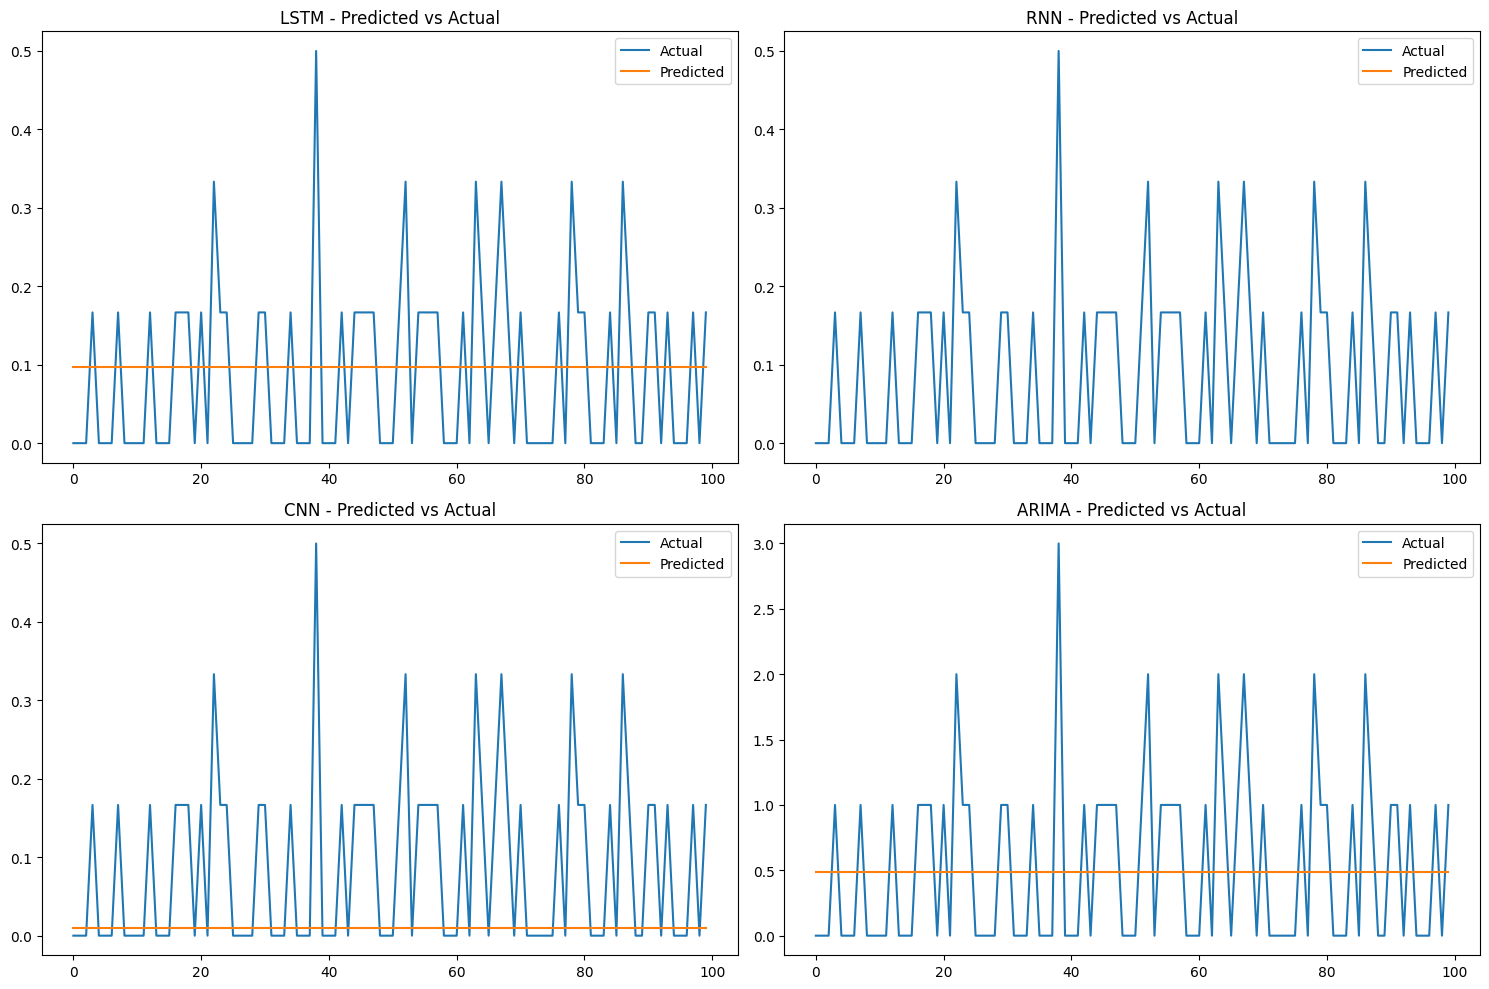

In [53]:
# Plot predictions vs actual for test set (first 100 points)
plot_range = 100

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, model in enumerate(models):
    ax = axes[i]
    if model == 'ARIMA':
        actual = test_sales[:plot_range]
        pred = test_preds[i][:plot_range]
    else:
        actual = y_test[:plot_range].flatten()
        pred = test_preds[i][:plot_range].flatten()
    
    ax.plot(actual, label='Actual')
    ax.plot(pred, label='Predicted')
    ax.set_title(f'{model} - Predicted vs Actual')
    ax.legend()

plt.tight_layout()
plt.show()

### Conclusion

Based on the evaluation metrics, the LSTM model performed the best with the lowest RMSE and MAE on both validation and test sets. This is expected as LSTMs are designed to capture long-term dependencies in time series data. The CNN model also performed well, likely due to its ability to extract local patterns. The RNN model showed moderate performance, while ARIMA served as a good baseline but was outperformed by the neural network models. For production use, further tuning and ensemble methods could be explored.